# DDPG with PyTorch

Same experiment using PyTorch instead of TF

Model-free, off-policy RL method.

Two networks here:
 - Actor: Proposes an action
 - Critic: Evaluates action based on new state, reward

In [1]:
import gym
import sys
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import deque

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

In [2]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=.1, is_relative_detach=False):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0)#.to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.output_size = output_size
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        torch.nn.init.uniform_(self.linear3.weight, a=0.1, b=0.5)
        
        self.noise = GaussianNoise()
        
    def forward(self, state, noise=False):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        
        if noise:
            return self.noise.forward(x)
        else:
            return x

In [3]:
class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [4]:
### DDPG Agent

class DDPGagent:
    def __init__(self, env_obs, env_acts, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3,\
                 gamma=0.99, tau=0.005, max_memory_size=50000):
        # Params
        self.num_states = env_obs
        self.num_actions = env_acts
        self.gamma = gamma
        self.tau = tau
        
        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state, noise):
        state = np.array(state)
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state, noise)
        action = action

        return np.squeeze(action)
    
    def update(self, batch_size, path_to_save=[]):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
       
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
        
        if len(path_to_save) > 0:
            torch.save(self.actor, path_to_save[0])
            torch.save(self.critic, path_to_save[1])

In [21]:
### Run training

def cross_validation(agent, env, iteration):
    batch_size = 8
    rewards = []
    avg_rewards = []
    exploitation_rewards = []
    total_rewards = []
    num_episodes = 200
    action_history = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_info = {}
        

        while True:
            action = agent.get_action(state, noise=True) # Gets action from DDPG agent
            action = np.asarray([np.squeeze(action.detach().numpy())])
            if episode % 5 == 0 and episode > 0:
                action = agent.get_action(state, noise=False)
                action = np.asarray([np.squeeze(action.detach().numpy())])
            new_state, reward, done, info = env.step(action) 
            episode_info['reward'] = reward
            agent.memory.push(state, action, reward, new_state, done)

            if len(agent.memory) > batch_size and episode < num_episodes-1:
                agent.update(batch_size)  
            elif len(agent.memory) > batch_size and episode == num_episodes-1:
                agent.update(batch_size, path_to_save=["./saved_models/trained_actor.pt",
                                                       "./saved_models/trained_critic.pt"])

            state = new_state
            episode_reward += reward
            action_history.append(action.squeeze())

            if done:
                break

        rewards.append(episode_reward)
        avg_rewards.append(np.mean(rewards[-50:]))
        if episode % 5 == 0 and episode > 0:
            exploitation_rewards.append(episode_reward)
        
    data = {'Rewards':rewards,
           'Avg_rewards':avg_rewards}
    results = pd.DataFrame(data)        
    
    return results, action_history, exploitation_rewards

## Training hyperparameters

In [6]:
from ray import serve

from config import Config
from data_prep import DataPrep
from env_no_serve import CMAPSSEnv
from tf_decoder_model import TFDecoderModel
from VAE_dense import *

In [7]:
const = Config()
neurons = const.VAE_neurons

# Data prep
data = DataPrep(file = const.file_path,
                num_settings = const.num_settings,
                num_sensors = const.num_sensors,
                num_units = const.num_units[1],
                prev_step_units = const.prev_step_units[1],
                step = const.step[1],
                normalization_type="01")

df = data.ReadData()

In [10]:
# List of engine lifetimes
engine_lives = df.groupby(df['Unit']).size().tolist()
num_engines = len(engine_lives)

# Load decoder
decoder = tf.keras.models.load_model('./saved_models/decoder', compile=False)

# Environment types
env_types = ["batch", "intertemporal"]

##########################################
env_config = {
    "df": df,
    "timestep": 0,
    "obs_size": const.num_settings+const.num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "decoder_model": decoder,
    "env_type": env_types[0],
}

env = CMAPSSEnv(**env_config)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print(upper_bound, lower_bound)

Size of State Space ->  25
Size of Action Space ->  1
1.0 0.0


In [22]:
agent = DDPGagent(env.observation_space.shape[0],env.action_space.shape[0])
results, action_history, exploitation_rewards = cross_validation(agent, env, iteration=1)

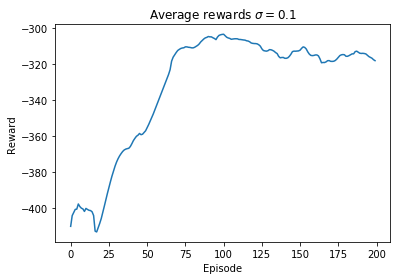

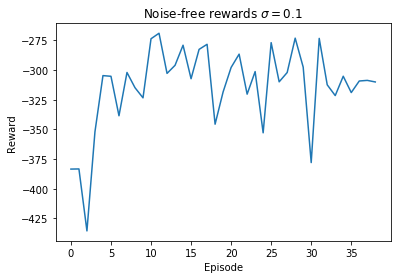

In [23]:
# Plot results
plt.plot(results['Avg_rewards'])
plt.title(r'Average rewards $\sigma=0.1$')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(exploitation_rewards)
plt.title(r'Noise-free rewards $\sigma=0.1$')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.show()

## Evaluate policy

In [25]:
# Test data
t_data = DataPrep(file = const.file_path,
                num_settings = const.num_settings,
                num_sensors = const.num_sensors,
                num_units = const.num_units[2],
                prev_step_units = const.prev_step_units[2],
                step = const.step[2],
                normalization_type="01")

test_df = t_data.ReadData()
test_df

,Unit,NormTime,OpSetting1,OpSetting2,OpSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,211,0.995327,0.833248,0.997625,1.0,0.060269,0.187903,0.333902,0.225908,0.146592,...,0.136443,0.993796,0.564038,0.343278,0.0,0.308511,0.651163,1.0,0.163861,0.165210
1,211,0.990654,0.999919,0.997862,1.0,0.000000,0.133493,0.286198,0.207650,0.000000,...,0.003173,0.993658,0.599009,0.367114,0.0,0.287234,0.627907,1.0,0.017863,0.021717
2,211,0.985981,0.476059,0.833017,1.0,0.626985,0.662033,0.643966,0.535748,0.507937,...,0.473287,0.993824,0.548079,0.321170,0.0,0.638298,0.864693,1.0,0.494675,0.493584
3,211,0.981308,0.999781,0.997625,1.0,0.000000,0.130731,0.302533,0.234678,0.000000,...,0.004391,0.993769,0.594056,0.364319,0.0,0.276596,0.627907,1.0,0.014772,0.018016
4,211,0.976636,0.833160,0.997625,1.0,0.060269,0.184588,0.324665,0.235570,0.146592,...,0.136621,0.994045,0.563088,0.344013,0.0,0.297872,0.651163,1.0,0.154930,0.160667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10266,260,0.012658,0.476188,0.831354,1.0,0.626985,0.674461,0.682297,0.591067,0.507937,...,0.468871,0.996250,0.803507,0.351775,1.0,0.691489,0.864693,1.0,0.485400,0.482746
10267,260,0.009494,0.238102,0.298100,1.0,0.597937,0.647026,0.733008,0.726354,0.617180,...,0.613969,0.994596,0.992921,0.151333,1.0,0.744681,0.854123,1.0,0.613878,0.621748
10268,260,0.006329,0.595222,0.736342,0.0,0.238089,0.017952,0.088067,0.066888,0.293184,...,0.087384,0.007279,0.307234,1.000000,0.0,0.063830,0.000000,0.0,0.136036,0.140835
10269,260,0.003165,0.595203,0.738717,0.0,0.238089,0.021267,0.079155,0.087648,0.293184,...,0.088983,0.007334,0.310286,0.995586,0.0,0.074468,0.000000,0.0,0.131226,0.130673


In [26]:
# List of engine lifetimes
engine_lives = test_df.groupby(test_df['Unit']).size()
engine_lives = engine_lives.tolist()
num_engines = len(engine_lives)

print(engine_lives, num_engines)

[214, 149, 196, 146, 226, 229, 162, 237, 156, 234, 178, 195, 218, 174, 156, 178, 184, 262, 176, 186, 144, 242, 190, 159, 183, 239, 209, 156, 263, 266, 183, 273, 230, 128, 253, 194, 197, 234, 202, 184, 266, 135, 149, 260, 340, 163, 309, 143, 205, 316] 50


In [27]:
##########################################
env_config = {
    "df": test_df,
    "timestep": 0,
    "obs_size": const.num_settings+const.num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "decoder_model": decoder,
    "env_type": env_types[0],
}

#print("env_config: ", env_config)

In [28]:
actor = torch.load("./saved_models/trained_actor.pt")

est_rul = []
est_sensor1 = []
action_vector = []

#for s in range(len(test_df)):
obs = env.reset()
for t in range(engine_lives[0]):
    action = actor.forward(torch.FloatTensor(test_df.iloc[t,1:].tolist()))
    action = np.asarray([np.squeeze(action.detach().numpy())])
    action_vector.append(action)
    obs, rew, done, _ = env.step(action)
    est_rul.append(obs[0])
    est_sensor1.append(obs[5])
    #print(obs)
#print(est_rul)

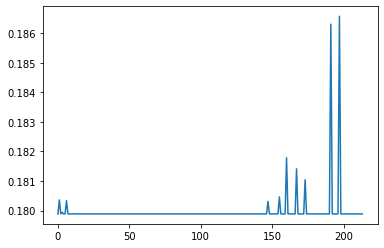

In [29]:
plt.plot(est_rul)
plt.show()